<a href="https://colab.research.google.com/github/Deep-of-Machine/AI_Academy/blob/main/5_3_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch를 사용한 MLP 구현

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import torch

## CPU로 학습

In [2]:
torch.cuda.is_available()

True

## 데이터셋 전처리와 다운로드
torchvision : PyTorch와 밀접한 연관이 있는 라이브러리. 이미지와 비디오를 다루는 여러 도구를 제공    
https://pytorch.org/vision/stable/index.html 에서 torchvision 등의 설명 확인 가능    
datasets.MNIST(PATH, transform) : 인터넷에서 MNIST 데이터셋을 다운로드해서 'PATH'에 저장.    
transforms.ToTensor() : 텐서 형식으로 변형    

In [3]:
from torchvision import datasets, transforms
train_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = './data', train = False, download = True, transform = transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


지정한 경로에 제대로 다운 받았는지 확인

In [4]:
os.listdir('/content/data')

['MNIST']

In [5]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

## 데이터로더
학습에 사용하기 위한 데이터를 **미니 배치 사이즈 만큼** 가져와서 사용하기 위한 함수

In [6]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

이미지의 미니 배치는 (배치 사이즈, 채널, 높이, 폭)의 모양으로 주어진다.    
신경망의 입력으로 사용할 때도 이와 같은 모양을 사용해야 한다.

첫번째 배치 확인

In [7]:
for mini_batch in train_loader:
    first_batch = mini_batch

    break

print(type(first_batch))

<class 'list'>


In [8]:
print(len(first_batch))

2


첫번째 배치에서 이미지와 라벨을 분리

In [9]:
print(type(first_batch[0]))
print(type(first_batch[1]))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [10]:
print(first_batch[0].shape)
print(first_batch[1].shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [11]:
image, label = first_batch[0], first_batch[1]

In [12]:
print(image[0].shape)

torch.Size([1, 28, 28])


In [13]:
print(image[0].squeeze().shape)

torch.Size([28, 28])


이미지를 출력하기 위해선 numpy 형식의 데이터로 변경해야한다

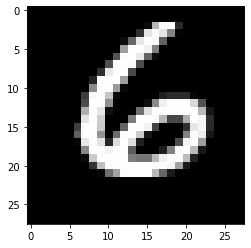

label : 6


In [14]:
plt.imshow(image[0].squeeze().numpy(), cmap = 'gray')
plt.show()
print('label :', label[0].item())

## 신경망 구성


### 완전연결층 예시
랜덤으로 생성한 random_input을 샘플로 사용    
nn.Linear(in_dim, out_dim) : in_dim 갯수의 입력 노드와 out_dim 갯수의 출력 
노드를 완전연결하는 가중치와 편향을 만들어줌 

In [15]:
import torch.nn as nn

In [16]:
w1 = nn.Linear(28*28, 100)

생성된 가중치와 편향 확인

In [17]:
w1.weight

Parameter containing:
tensor([[-0.0300, -0.0069, -0.0148,  ..., -0.0250,  0.0074, -0.0286],
        [-0.0016,  0.0296, -0.0168,  ...,  0.0202, -0.0134, -0.0341],
        [ 0.0236, -0.0254, -0.0232,  ...,  0.0081,  0.0064,  0.0199],
        ...,
        [-0.0098,  0.0010, -0.0201,  ...,  0.0252, -0.0072, -0.0235],
        [ 0.0283, -0.0326, -0.0248,  ...,  0.0098, -0.0342, -0.0126],
        [-0.0184, -0.0080,  0.0185,  ...,  0.0066,  0.0225,  0.0077]],
       requires_grad=True)

In [18]:
w1.bias

Parameter containing:
tensor([ 0.0241,  0.0038, -0.0074, -0.0081,  0.0016, -0.0319, -0.0046,  0.0050,
        -0.0306,  0.0355, -0.0093,  0.0077, -0.0157, -0.0276, -0.0262,  0.0276,
        -0.0049,  0.0036, -0.0325, -0.0156, -0.0245,  0.0249, -0.0111, -0.0323,
        -0.0225,  0.0338, -0.0129, -0.0272, -0.0228, -0.0356, -0.0206,  0.0349,
         0.0239, -0.0283,  0.0118,  0.0058,  0.0345,  0.0025,  0.0224,  0.0051,
         0.0023, -0.0256, -0.0349, -0.0088, -0.0237, -0.0044,  0.0209, -0.0260,
        -0.0332,  0.0304, -0.0346,  0.0001,  0.0049,  0.0176,  0.0280, -0.0346,
        -0.0044,  0.0039,  0.0267,  0.0055, -0.0334,  0.0218,  0.0081, -0.0074,
         0.0280,  0.0238,  0.0186,  0.0247,  0.0330,  0.0082,  0.0132,  0.0282,
        -0.0174,  0.0149,  0.0098,  0.0345, -0.0140, -0.0125, -0.0111, -0.0219,
        -0.0317,  0.0174, -0.0251, -0.0151, -0.0004,  0.0307,  0.0134,  0.0200,
        -0.0139, -0.0080,  0.0311, -0.0241,  0.0244, -0.0352,  0.0085, -0.0177,
         0.0213,  

In [19]:
w2 = nn.Linear(100, 30)
w3 = nn.Linear(30, 10)

In [20]:
image[0].shape

torch.Size([1, 28, 28])

In [21]:
w1(image[0].flatten())

tensor([-9.8625e-02, -2.6122e-04, -1.2757e-01,  1.6491e-01, -2.1654e-02,
         2.3421e-01,  1.0082e-01, -2.0139e-01, -2.8074e-02,  1.2453e-01,
         3.9678e-02, -1.1518e-01, -1.1624e-01, -7.3183e-02,  6.9326e-02,
         9.6854e-02,  1.9924e-03, -2.0998e-01, -9.5300e-02, -6.9445e-02,
        -3.0511e-01, -2.4510e-01,  3.9635e-02, -1.2959e-01,  2.0476e-01,
         7.6595e-02, -9.3433e-02, -9.5751e-02, -1.5587e-01,  1.6638e-01,
        -1.3722e-01,  1.2262e-01,  3.6528e-02,  3.5955e-01, -1.6091e-01,
         1.0486e-03,  7.1433e-02,  1.0374e-01, -1.8140e-01, -3.1571e-01,
         2.1391e-01, -4.8941e-01,  5.1931e-02, -1.0601e-01, -2.3463e-01,
        -2.5476e-01, -1.7576e-01,  2.6056e-01, -7.6457e-02, -5.7305e-02,
        -2.5921e-01, -4.4766e-01,  3.7931e-01,  3.2060e-01, -1.1795e-02,
         1.8594e-01,  3.2026e-01, -1.2854e-01, -1.5767e-01,  1.1454e-01,
        -3.0334e-01,  1.6683e-01,  3.2692e-01,  1.7116e-01,  1.8619e-01,
        -2.4697e-01,  1.0533e-01,  4.4741e-02, -2.1

직접 생성한 가중치와 편향을 사용하는 완전연결층

In [22]:
x = image[0].flatten()
z1 = w1(x)
a1 = nn.Sigmoid()(z1)

In [23]:
z2 = w2(a1)
a2 = nn.Sigmoid()(z2)
z3 = w3(a2)
a3 = nn.Softmax()(z3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


활성화함수 작동

신경망 클래스 정의

In [24]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.w1 = nn.Linear(28*28, 100)
        self.w2 = nn.Linear(100, 30)
        self.w3 = nn.Linear(30, 10)

    def forward(self, x):
        z1 = self.w1(x)
        a1 = nn.Sigmoid()(z1)
        z2 = self.w2(a1)
        a2 = nn.Sigmoid()(z2)
        z3 = self.w3(a2)
        a3 = nn.Softmax()(z3)
        return a3

이번에 사용할 모델은 위에서 정의한 신경망(MyNet)을 사용

In [25]:
model = MyNet()
print(model)

MyNet(
  (w1): Linear(in_features=784, out_features=100, bias=True)
  (w2): Linear(in_features=100, out_features=30, bias=True)
  (w3): Linear(in_features=30, out_features=10, bias=True)
)


길이 784의 입력값을 임의로 생성해서 모델의 출력 결과 확인

In [26]:
output = model(image[0].flatten())
print(output.size())

torch.Size([10])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [27]:
random_input = torch.rand(784)
output = model(random_input)
print(random_input.shape)
print(output.size())

torch.Size([784])
torch.Size([10])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


numpy 형식의 데이터를 입력으로 사용할 경우 에러 발생

In [28]:
# np_array = random_input.numpy()
# output = model(np_array)

첫번째 은닉층에 연결된 가중치 확인

In [29]:
model

MyNet(
  (w1): Linear(in_features=784, out_features=100, bias=True)
  (w2): Linear(in_features=100, out_features=30, bias=True)
  (w3): Linear(in_features=30, out_features=10, bias=True)
)

In [30]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0141, -0.0094, -0.0300,  ...,  0.0128,  0.0083,  0.0013],
         [ 0.0059,  0.0060,  0.0261,  ..., -0.0114, -0.0281,  0.0234],
         [ 0.0189,  0.0177,  0.0189,  ..., -0.0011,  0.0005,  0.0077],
         ...,
         [ 0.0328, -0.0206, -0.0252,  ..., -0.0301, -0.0032,  0.0112],
         [-0.0008, -0.0247, -0.0284,  ...,  0.0314,  0.0207,  0.0184],
         [-0.0009, -0.0070,  0.0140,  ..., -0.0147,  0.0040,  0.0235]],
        requires_grad=True), Parameter containing:
 tensor([-0.0284,  0.0187,  0.0300,  0.0004, -0.0118,  0.0136, -0.0179, -0.0141,
         -0.0028,  0.0325, -0.0307, -0.0214, -0.0032, -0.0204, -0.0211,  0.0286,
         -0.0272,  0.0149, -0.0042,  0.0172,  0.0270,  0.0092, -0.0328,  0.0186,
          0.0254, -0.0111,  0.0142, -0.0340, -0.0315,  0.0258, -0.0047, -0.0335,
         -0.0005, -0.0212, -0.0160, -0.0237, -0.0173,  0.0077, -0.0253,  0.0331,
          0.0094, -0.0193, -0.0169, -0.0205,  0.0089, -0.0214, -0.0050, -0.0151,

In [31]:
len(list(model.parameters()))

6

In [32]:
list(model.parameters())[0].shape

torch.Size([100, 784])

첫번째 은닉층에 연결된 편향 확인

In [33]:
list(model.parameters())[1].shape

torch.Size([100])

배치 사이즈 64의 입력을 사용하는 경우

In [34]:
random_input = torch.rand(64, 784)
output = model(random_input)
print(random_input.shape)
print(output.size())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


torch.Size([64, 784])
torch.Size([64, 10])


손실 함수와 최적화 기법

In [35]:
from torch import optim
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

### 모델 학습

In [37]:
epochs = 30

for epoch in range(epochs):
    running_loss = 0.0
    start_time = time.time()

    for inputs, labels in train_loader:
        #inputs.shape = [64,1,28,28] -> [64, 1*28*28]
        inputs = inputs.view(inputs.shape[0], -1)
        labels = labels
        outputs = model(inputs)

        loss = loss_func(outputs, labels)
        optimizer.zero_grad()    # 경사 초기화
        loss.backward()          # 경사 계산
        optimizer.step()         # 계산한 경사를 바탕으로 파라미터 업데이트

        running_loss += loss.item()

    end_time = time.time()

    print('Epoch : {}, Loss : {}, time : {}'.format(epoch + 1, running_loss/len(train_loader), end_time - start_time))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Epoch : 1, Loss : 1.9261028316737747, time : 9.354567766189575
Epoch : 2, Loss : 1.8630238456258388, time : 9.260818719863892
Epoch : 3, Loss : 1.8120527961360875, time : 9.256989479064941
Epoch : 4, Loss : 1.7636230102480093, time : 9.232709169387817
Epoch : 5, Loss : 1.726958925027583, time : 9.221630334854126
Epoch : 6, Loss : 1.6890111743514218, time : 9.238845109939575
Epoch : 7, Loss : 1.6570876702062611, time : 9.29160189628601
Epoch : 8, Loss : 1.6311656461595727, time : 9.29251480102539
Epoch : 9, Loss : 1.6103194494491446, time : 9.252273559570312
Epoch : 10, Loss : 1.59422446796889, time : 9.234498500823975
Epoch : 11, Loss : 1.582027717948214, time : 9.346262216567993
Epoch : 12, Loss : 1.572577793460919, time : 9.167054891586304
Epoch : 13, Loss : 1.5650101529001428, time : 9.287025451660156
Epoch : 14, Loss : 1.5587880338178768, time : 9.062036991119385
Epoch : 15, Loss : 1.5536708306910387, time : 9.25431489944458
Epoch : 16, Loss : 1.5493076720725754, time : 9.180549621

### 모델 평가

In [38]:
for mini_batch in test_loader:
    first_batch = mini_batch
    break

inputs = first_batch[0]
labels = first_batch[1]
outputs = model(inputs.view(inputs.shape[0], -1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [39]:
inputs.shape, labels.shape, outputs.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]), torch.Size([64, 10]))

In [40]:
print(outputs[0])
print(torch.argmax(outputs[0]))

tensor([2.0510e-05, 7.0799e-05, 1.2889e-06, 5.1929e-06, 3.1174e-06, 1.2870e-04,
        5.4995e-07, 9.9960e-01, 1.1703e-06, 1.7102e-04],
       grad_fn=<SelectBackward>)
tensor(7)


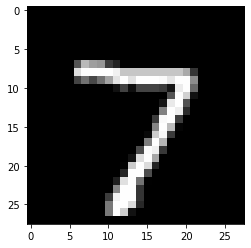

예측 : 7
라벨 : 7


In [41]:
sample_number = 0
plt.imshow(inputs[sample_number].squeeze().numpy(), cmap = 'gray')
plt.show()
print('예측 : {}'.format(torch.argmax(outputs[sample_number]).item()))
print('라벨 : {}'.format(labels[sample_number].item()))

전체 테스트 데이터에 대한 정확도 계산

In [42]:
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.view(inputs.shape[0], -1))
        predicted = torch.argmax(outputs, dim = 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # 아래에 추가 설명

    print(total)
    print(100*correct / total)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


10000
94.55


In [43]:
x = torch.tensor([1,2,3,4])
y = torch.tensor([1,2,4,8])

print(x == y)

tensor([ True,  True, False, False])


In [44]:
print((x == y).sum())

tensor(2)


In [45]:
print((x == y).sum().item())

2
